In [1]:
import pandas as pd
from zipline.api import symbol, set_benchmark, order,record, order_target, get_open_orders
from zipline.utils.calendar_utils import get_calendar
from zipline import run_algorithm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_amz = pd.read_csv('custom_data/AMZN.csv')
data_amz.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-12-06,80.743500,85.052498,80.492500,84.959503,84.959503,175788000
1,2018-12-07,85.253502,85.946503,81.273003,81.456497,81.456497,151522000
2,2018-12-10,81.192001,82.899498,79.543503,82.051498,82.051498,149896000
3,2018-12-11,83.900002,83.973503,80.980003,82.162003,82.162003,124894000
4,2018-12-12,83.449997,85.249496,83.013496,83.177002,83.177002,131960000


In [3]:
data_amz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


Volume column is in int64

**Convert volume column to float64**

In [4]:
data_amz.Volume= data_amz.Volume.astype('float64')
data_amz.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

**Convert all columns to lower case**

In [5]:
data_amz.columns = data_amz.columns.str.lower()

In [6]:
data_amz.head()

,date,open,high,low,close,adj close,volume
0,2018-12-06,80.743500,85.052498,80.492500,84.959503,84.959503,175788000.0
1,2018-12-07,85.253502,85.946503,81.273003,81.456497,81.456497,151522000.0
2,2018-12-10,81.192001,82.899498,79.543503,82.051498,82.051498,149896000.0
3,2018-12-11,83.900002,83.973503,80.980003,82.162003,82.162003,124894000.0
4,2018-12-12,83.449997,85.249496,83.013496,83.177002,83.177002,131960000.0


**Rename the data column as  timestamp to fit it zipline**

In [7]:
data_amz = data_amz.rename(columns={"date" : "timestamp"})

In [8]:
data_amz.head()

,timestamp,open,high,low,close,adj close,volume
0,2018-12-06,80.743500,85.052498,80.492500,84.959503,84.959503,175788000.0
1,2018-12-07,85.253502,85.946503,81.273003,81.456497,81.456497,151522000.0
2,2018-12-10,81.192001,82.899498,79.543503,82.051498,82.051498,149896000.0
3,2018-12-11,83.900002,83.973503,80.980003,82.162003,82.162003,124894000.0
4,2018-12-12,83.449997,85.249496,83.013496,83.177002,83.177002,131960000.0


In [9]:
data_amz.set_index('timestamp',inplace=True)
data_amz.head()

,open,high,low,close,adj close,volume
timestamp,,,,,,
2018-12-06,80.743500,85.052498,80.492500,84.959503,84.959503,175788000.0
2018-12-07,85.253502,85.946503,81.273003,81.456497,81.456497,151522000.0
2018-12-10,81.192001,82.899498,79.543503,82.051498,82.051498,149896000.0
2018-12-11,83.900002,83.973503,80.980003,82.162003,82.162003,124894000.0
2018-12-12,83.449997,85.249496,83.013496,83.177002,83.177002,131960000.0


In [10]:
data_amz.to_csv('custom_data/daily/amazon.csv')

In [3]:
!zipline bundles;

amz1 2023-12-27 14:53:18.695381
csvdir <no ingestions>
quandl 2023-11-29 14:09:18.799451
quandl 2023-11-29 14:07:32.423012
quandl 2023-11-29 12:39:15.374615
quandl 2023-11-29 12:05:56.774662
quandl 2023-11-29 10:27:35.030664
quantopian-quandl 2023-11-30 02:02:00.355768
quantopian-quandl 2023-11-30 01:12:56.278980
quantopian-quandl 2023-11-30 01:11:49.450274
quantopian-quandl 2023-11-29 14:06:08.862893
quantopian-quandl 2023-11-29 13:55:59.391084
quantopian-quandl 2023-11-29 12:17:04.159981
quantopian-quandl 2023-11-29 10:27:07.529834
quantopian-quandl 2023-11-29 10:14:48.887188


In [12]:
# !zipline ingest -b amazon_yfinance

In [4]:
syb = 'amazon'
calendar = get_calendar('XNYS')
short = 20
long = 70
capital_base = 10000

def initialize(context):
    context.i = 0
    context.asset = symbol(syb)
    
def handle_data(context, data):
    context.i += 1
    if context.i < long: return
    
    short_mavg = data.history(context.asset,'price', bar_count=30, frequency='1d').mean()
    long_mavg = data.history(context.asset,'price', bar_count=90, frequency='1d').mean()
    
    open_orders = get_open_orders()
    if context.asset not in open_orders:
        if short_mavg > long_mavg:
            order_target(context.asset,10)
        else:
            order_target(context.asset,0)
    
    record(price = data.current(context.asset,'price'),
            short_mavg=short_mavg,
            long_mavg=long_mavg
            )

In [5]:
%%capture

start_date = pd.to_datetime('2019-06-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2020-06-01', format='%Y-%m-%d')

result_2022_onward = run_algorithm(
    start = start_date,
    end = end_date,
    initialize=initialize,
    handle_data = handle_data,
    trading_calendar=calendar,
    bundle='amz1',
    capital_base=capital_base,
    data_frequency='daily'
)

In [6]:
result_2022_onward.head()

,period_open,period_close,ending_exposure,shorts_count,starting_cash,long_value,portfolio_value,short_value,long_exposure,starting_exposure,...,max_drawdown,algo_volatility,max_leverage,excess_return,treasury_period_return,trading_days,period_label,price,short_mavg,long_mavg
2019-06-03 20:00:00+00:00,2019-06-03 13:31:00+00:00,2019-06-03 20:00:00+00:00,0.0,0,10000.0,0.0,10000.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,1,2019-06,NaN,NaN,NaN
2019-06-04 20:00:00+00:00,2019-06-04 13:31:00+00:00,2019-06-04 20:00:00+00:00,0.0,0,10000.0,0.0,10000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,2019-06,NaN,NaN,NaN
2019-06-05 20:00:00+00:00,2019-06-05 13:31:00+00:00,2019-06-05 20:00:00+00:00,0.0,0,10000.0,0.0,10000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3,2019-06,NaN,NaN,NaN
2019-06-06 20:00:00+00:00,2019-06-06 13:31:00+00:00,2019-06-06 20:00:00+00:00,0.0,0,10000.0,0.0,10000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4,2019-06,NaN,NaN,NaN
2019-06-07 20:00:00+00:00,2019-06-07 13:31:00+00:00,2019-06-07 20:00:00+00:00,0.0,0,10000.0,0.0,10000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5,2019-06,NaN,NaN,NaN


<Axes: >

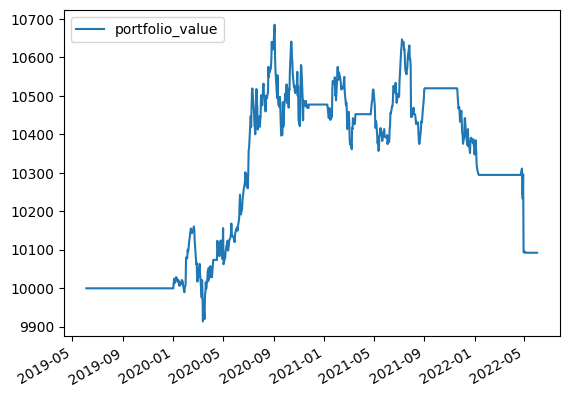

In [22]:
result_2022_onward.portfolio_value.plot(legend=True)

<Axes: >

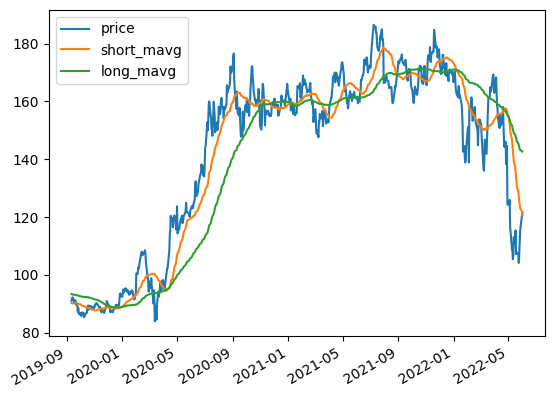

In [17]:
result_2022_onward.price.plot(legend=True)
result_2022_onward.short_mavg.plot(legend=True)
result_2022_onward.long_mavg.plot(legend=True)
